# Problem Definition

> Train a model to predict the avocado price in Denver using avocado prices from all other regions. Explain how you evaluate the performance of the model and relative importance of its features.

> I am using all the given features and all records of given region to predict prices in a different region. Features used are all the columns given in the dataset plus lagged values of price and volume. This approach assumes that you have all feature information except for the price in the desired region. Linear Regression, Random Forest and Xgboost were used for training and XGBOOST was selected based on the RMSE and MAPE metrics. The final model is presented in a separate python file.

> This might not bea best use-case for modeling. Single time series forecasting is done in a different notebook. Also, this notebook shows how to evaluate models using different metrics and get feature importance given a model and also error analysis using SHAPLEY values.

In [1]:
# import packages for data manipulation
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import janitor

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../avocado.csv")
df.shape

(18249, 14)

In [3]:
# Removing index column
df.drop('Unnamed: 0', axis=1, inplace=True)

# Removing records with TotalUS region, assuming it is nust the average of all other regions
df = df.loc[df.region!='TotalUS'].reset_index(drop=True)

# Making date to datetime and sorting chrinologically
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['region','Date'])
df = df.clean_names()

In [4]:
# Adding month and day variable to visualize seasonal patterns
df['month']=df['date'].apply(lambda x:x.month)
df['day']=df['date'].apply(lambda x:x.day)
for lag in range(1,11):
    df[f'lag_{lag}'] = df.groupby(['region'])['averageprice'].shift(lag)
df['long_term_moving_average'] = df.groupby(['region','type'])['averageprice'].transform(lambda x: x.rolling(window=52,min_periods=1).mean())
df['short_term_moving_average'] = df.groupby(['region','type'])['averageprice'].transform(lambda x: x.rolling(window=12,min_periods=1).mean())
df['is_SMA_greater'] = (df['short_term_moving_average'] > df['long_term_moving_average'])

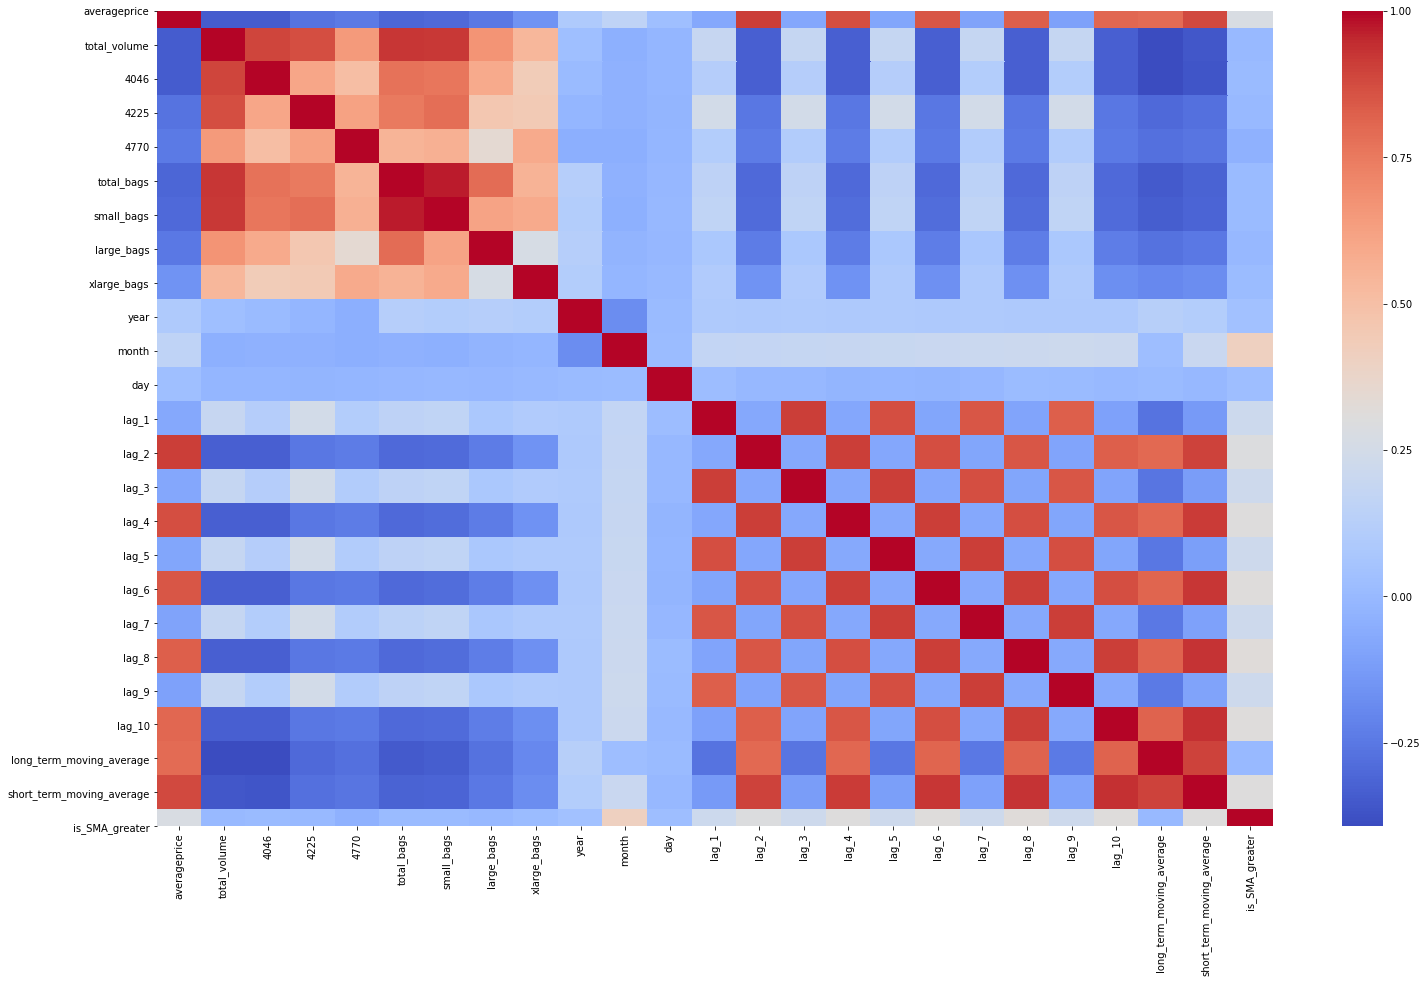

In [5]:
plt.figure(figsize=(25,15));
sns.heatmap(df.corr(),cmap='coolwarm',annot=False);

> **Most numerical columns are negatively correlated with price as they are variables associated with demand. Also lag2 is correlated the most with target variable**

# Feature Engineering

In [6]:
test = df.loc[df.region=='Denver'].reset_index(drop=True)
train = df.loc[df.region!='Denver'].reset_index(drop=True)

In [7]:
import pickle
def preprocessing(df, train=True):
    
    df = pd.get_dummies(df, columns = ['type'], prefix=['type'])
    num_columns = ['total_volume','4046','4225','4770','total_bags','small_bags', 'large_bags', 'xlarge_bags']

    if train:
        sc = StandardScaler()
        scaled_columns = sc.fit_transform(df[num_columns])
        scaled_df = pd.DataFrame(scaled_columns)
        scaled_df.columns = num_columns
        df = df.drop(num_columns,axis=1).join(scaled_df)
        pickle.dump(sc,open('scaler.p','wb'))
        
    else:
        sc = pickle.load(open('scaler.p','rb'))
        scaled_columns = sc.transform(df[num_columns])
        scaled_df = pd.DataFrame(scaled_columns)
        scaled_df.columns = num_columns
        df = df.drop(num_columns,axis=1).join(scaled_df)
    
    return df

In [8]:
train = preprocessing(train,train=True)
test = preprocessing(test,train=False)

In [9]:
y = train['averageprice']
date = train['date']
regions = train['region']
X = train.drop(['date','averageprice','region'],axis=1)

In [10]:
X.shape,y.shape,regions.shape

((17573, 26), (17573,), (17573,))

# Model Fitting

In [11]:
def custom_modeling(X, y, regions, test, n_folds, model):
    predictions=[]
    denver_preds = np.zeros(len(test))
    if model == 'linear':
        model = LinearRegression()
        title = 'Linear Regression'
    if model == 'RF':
        model = RandomForestRegressor(n_estimators=100)
        title = 'Random Forest'
    if model == 'Booster':
        
        params = {'colsample_bytree': 0.8, 
                  'gamma': 0.3, 
                  'max_depth': 7, 
                  'min_child_weight': 4, 
                  'subsample': 0.6,
                 'learning_rate':0.05,
                 'n_estimators':10000}
        model = XGBRegressor(**params)
        title = 'XGBoost'
    
    folds = GroupKFold(n_splits=n_folds)
    
    for i, (train_index, test_index) in enumerate(folds.split(X, y, regions)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        date_train, date_test = date[train_index], date[test_index]
        region_train, region_test = regions[train_index], regions[test_index]
        eval_set =  [(X_test, y_test)]
        if model=='Booster':
            model.fit(X_train,y_train,eval_metric="rmse", eval_set=eval_set, early_stopping_rounds=100,verbose=200)
        else:
            model.fit(X_train,y_train)
        pred=model.predict(X_test)
        print(f"Validation RMSE for fold {i}: {round(np.sqrt(mean_squared_error(y_test,pred)),3)}")
        predictions.append(pd.DataFrame({'date': date_test,'region':region_test,'actual_price':y_test, 'predicted_price':pred}))
        denver_preds += model.predict(test[X.columns])/5
        
    test['predicted_price'] = denver_preds
    test['error'] = test.averageprice - test.predicted_price
    mape = np.round(np.mean(np.abs(100*test.error/test.averageprice)), 2) 
    rmse = np.round(np.sqrt(mean_squared_error(test.averageprice,test.predicted_price)),2)
    r2 = np.round(r2_score(test.averageprice,test.predicted_price),2)
    plt.figure(figsize=(10,5));
    sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(test[['date','averageprice','predicted_price']], ['date']), err_style=None);
    plt.title(f'{title}\nActual vs Predicted Avocado price for Denver \n RMSE: {rmse} \n MAPE: {mape}% \n R2: {r2}');
    
    return model,predictions,test

In [12]:
#lm_model,lm_predictions,lm_test = custom_modeling(X, y, regions, test, 3, 'linear')

In [13]:
#rf_model,rf_predictions,rf_test = custom_modeling(X, y, regions, test, 5, 'RF')

Validation RMSE for fold 0: 0.138
Validation RMSE for fold 1: 0.142
Validation RMSE for fold 2: 0.161
Validation RMSE for fold 3: 0.131
Validation RMSE for fold 4: 0.114


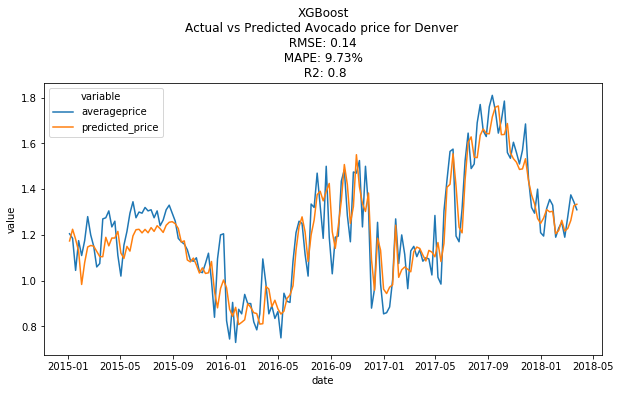

In [14]:
xgb_model,xgb_predictions,xgb_test = custom_modeling(X, y, regions, test, 5, 'Booster')

# Model evaluation

> This is a forecasting problem where we are trying to predict avocado prices. We can evaluate the model using the following metrics.
>* **R2 score** : The values for R2 range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the target variable.
>* **MAPE**: Mean absolute percentage error, For each record, the absolute error is divided by the actual value, giving relative error
>* **RMSE**: Root mean squared error, For each record, this measures how far the predicted value is from true error. 

> Based on all the above errors, XGBoost (ensemble decision tress) outperforms other models

# Feature Importance

> Let us use **Gain** score to measure the relative importance of the features in the model. **‘Gain’** is the improvement in accuracy metric brought by a feature to the branches it is on. 

In [15]:
importance = xgb_model.get_booster().get_score(importance_type= 'gain')
importance_df = pd.DataFrame(list(importance.items()), columns = ['feature','importance'])
importance_df = importance_df.sort_values('importance',ascending=False)

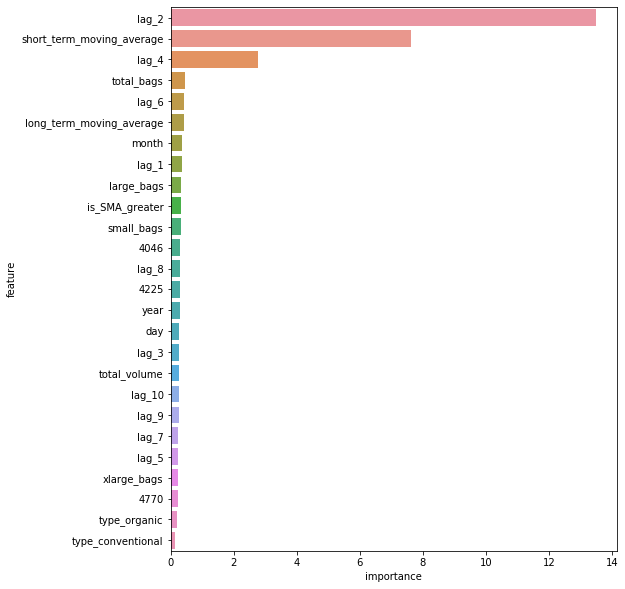

In [16]:
plt.figure(figsize=(8,10));
sns.barplot(importance_df.importance,importance_df.feature)
#plt.bar(importance_df.feature, importance_df.importance)
#plt.show()

# SHAPley values explanation

In [17]:
import shap
import warnings
explainer = shap.TreeExplainer(xgb_model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: 1.4245240205589238


# Entire dataset

In [18]:
X_features = test[X.columns]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(X_features)
    shap_interaction_values = explainer.shap_interaction_values(X_features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

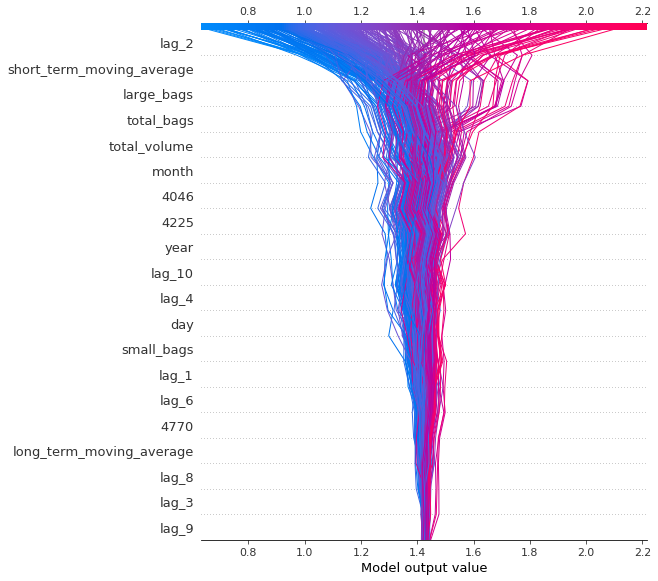

In [19]:
shap.decision_plot(expected_value, shap_values, X_features)

> Let us use Shapley values, mainly decision_plot to understand the working of our model and feature importances. 
The Decision plots shows th following 
* The x-axis represents the model's output. The y-axis lists the model's features. By default, the features are ordered by descending importance.The importance is calculated over the observations plotted. _This is usually different than the importance ordering for the entire dataset.
* The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.

> ** Looking at the plot, shapley values importances more or less agrees with the 'gain' score from xgboost importance. The most helpful insight from this plot is the 'typical' prediction path. The features at the bottom have zero to no effect in predicting the price month and year have some effect but still closer to the expected values. Real effect can be seen by the lag2, large_bags and volume. The predictions sway directions based in these features.**

# Few instances

In [20]:
select = range(10)
X_features = test[X.columns].iloc[select]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(X_features)
    shap_interaction_values = explainer.shap_interaction_values(X_features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

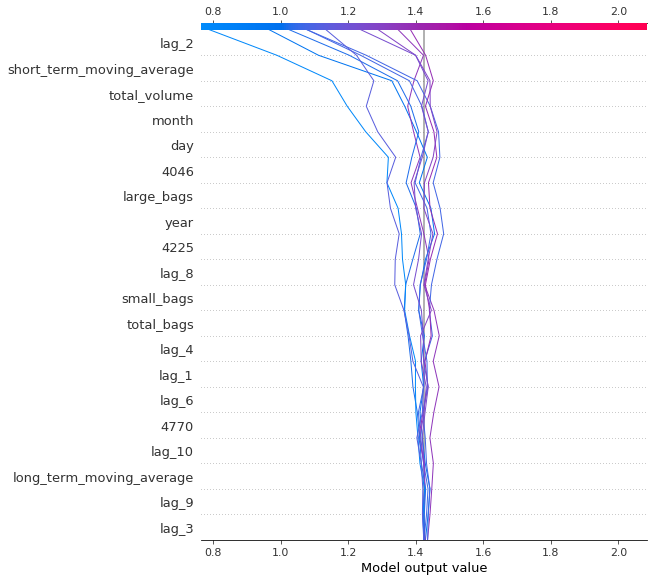

In [21]:
shap.decision_plot(expected_value, shap_values, X_features)

> ** This is a really great way to isolate records where we see that the error is high and checking which feature had the most effect**

# Records where difference between prediction and actual is high

In [22]:
error_indices = xgb_test.loc[(xgb_test.error<-0.4)|(xgb_test.error>0.2)].index.values
X_features = test[X.columns].iloc[error_indices]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(X_features)
    shap_interaction_values = explainer.shap_interaction_values(X_features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

In [23]:
test.iloc[error_indices][['date','year','month','region','type_conventional','averageprice','predicted_price','error']].head(10)

,date,year,month,region,type_conventional,averageprice,predicted_price,error
41,2015-05-24,2015,5,Denver,0,1.43,1.158844,0.271156
94,2015-11-29,2015,11,Denver,1,1.12,0.913931,0.206069
99,2015-12-13,2015,12,Denver,0,1.36,0.962045,0.397955
100,2015-12-20,2015,12,Denver,1,1.05,0.832825,0.217175
101,2015-12-20,2015,12,Denver,0,1.35,1.099138,0.250862
103,2015-12-27,2015,12,Denver,0,1.43,1.127713,0.302287
122,2016-03-06,2016,3,Denver,1,0.98,0.731400,0.248600
128,2016-03-27,2016,3,Denver,1,0.95,0.743538,0.206462
129,2016-03-27,2016,3,Denver,0,1.24,0.880277,0.359723
169,2016-08-14,2016,8,Denver,0,1.19,1.598897,-0.408897


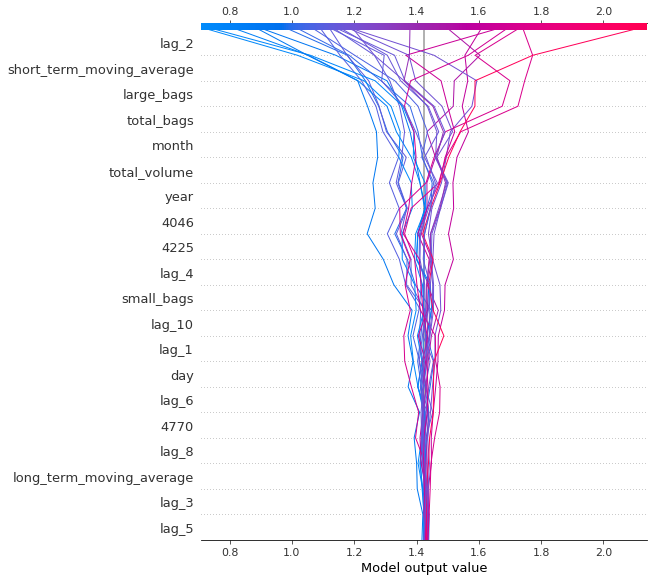

In [24]:
shap.decision_plot(expected_value, shap_values, X_features)

**Looking at the plot and examples of the cases where the model made a huge error, we can see that most of the records have price under $1 for 'organic' avocados which is an outlier. This pattern of low price for organic avocados is not captured by the model. One way to rectify is to build separate model so that model can rely on other features such as month, volume to understand the cases of lower prices in organic type.**

# Grid Search

In [27]:
# Various hyper-parameters to tune
xgb1 = XGBRegressor()
folds = GroupKFold(n_splits=5)
from sklearn.model_selection import GridSearchCV
params = {'min_child_weight':[4,5], 
          'gamma':[i/10.0 for i in range(3,6)], 
          'subsample':[i/10.0 for i in range(6,11)],
          'colsample_bytree':[i/10.0 for i in range(6,11)], 
          'max_depth': [4,5,6,7]}
         #'reg_alpha':[0.001,0.01,0.1,1,10,100], 
         #'reg_lambda':[0.001,0.01,0.1,1,10,100]}

xgb_grid = GridSearchCV(xgb1,
                        params,
                        cv = folds.split(X, y, regions),
                        n_jobs = 5,
                        verbose=True)
xgb_grid.fit(X, y)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   16.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  7.2min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 18.7min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 26.4min
[Parallel(n_jobs=5)]: Done 3000 out of 3000 | elapsed: 34.2min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x126694390>,
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'min_child_weight': [4, 5], 'gamma': [0.3, 0.4, 0.5], 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [28]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.8816446976850055
{'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.8}
